Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1000 external_states. See `.externals` for details.
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.r

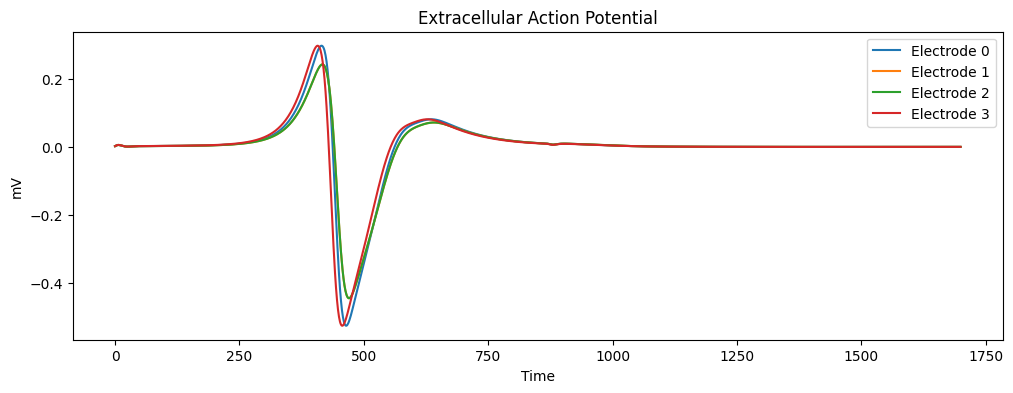

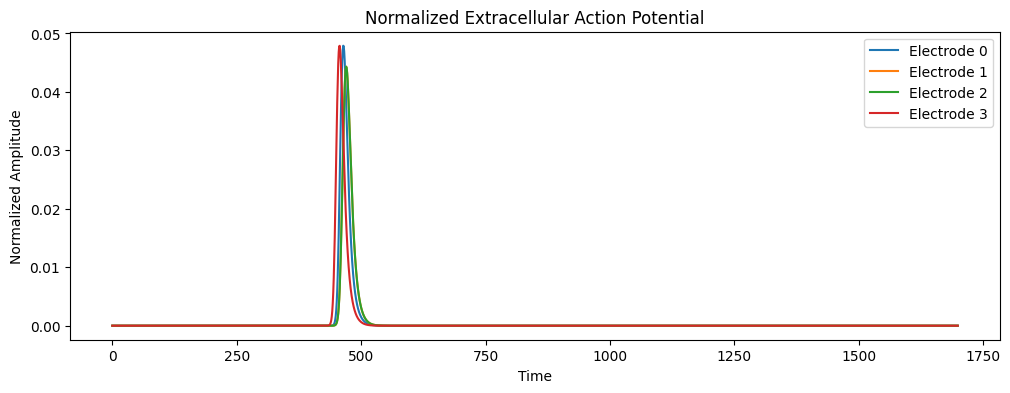

In [5]:
import straight_axon_model 
import jax.numpy as jnp
import jax
from loss_functions import sodium_peaks, diffusion_peaks, potassium_peaks, ei_widths, get_masked_eis, pairwise_time_differences


jax.config.update('jax_platform_name', 'cpu')  # Force GPU usage
jax.config.update('jax_enable_x64', True)
#jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
#jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
#jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
#jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")

cell = straight_axon_model.StraightAxon()
eap, mem_current, mem_voltage = cell.jitted_predict_ei(cell.params)
print('eap.shape', eap.shape)

# Upsample EAP by factor of 10 along time axis
import matplotlib.pyplot as plt

# Plot EAP for all 3 electrodes
plt.figure(figsize=(12, 4))
for i in range(eap.shape[1]):
    plt.plot(eap[:, i], label=f'Electrode {i}')
plt.title('Extracellular Action Potential')
plt.xlabel('Time')
plt.ylabel('mV')
plt.legend()


print('sodium peaks', sodium_peaks(eap))
print('capacitive peaks', diffusion_peaks(eap))
print('potassium peaks', potassium_peaks(eap))
print('ei widths', ei_widths(eap, 40))

pairwise_time_differences, normalized_ei = pairwise_time_differences(eap, component='sodium')
print('pairwise time differences', pairwise_time_differences)

# Plot normalized EI for all 3 electrodes
plt.figure(figsize=(12, 4))
for i in range(normalized_ei.shape[1]):
    plt.plot(normalized_ei[:, i], label=f'Electrode {i}')
plt.title('Softmaxed Extracellular Action Potential')
plt.xlabel('Time')
plt.ylabel('Normalized Amplitude')
plt.legend()

# loss = cell.jitted_loss(cell.inverse_sigmoid_transform_parameters(cell.params))
# print('loss', loss)

# # Sweep radius from 2 to 4 and compute loss
# radii = jnp.linspace(2.0, 4.0, 10)
# losses = []
# gradients = []
# from tqdm import tqdm
# for radius in tqdm(radii):
#     # Update params with current radius
#     params_copy = dict(cell.params)
#     params_copy["radius"] = jnp.array([radius])
    
#     # Transform params and compute loss
#     loss, grad = cell.jitted_grad(cell.inverse_sigmoid_transform_parameters(params_copy))
#     losses.append(float(loss))
#     gradients.append(float(grad["radius"][0]))
#     print(f"Radius: {radius:.2f}, Loss: {loss:.4f}")
# Plot radius vs loss
# plt.figure(figsize=(12, 5))
# plt.plot(radii, losses, label='Loss')
# plt.plot(radii, gradients, linestyle='--', label='Gradient')
# plt.title('Loss vs Radius')
# plt.xlabel('Radius (μm)')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.legend()




In [2]:
print(gradient)

{'HH_gK': Array([2.65845466], dtype=float64), 'HH_gNa': Array([-5.90453255], dtype=float64), 'axial_resistivity': Array([13.36546951], dtype=float64), 'axon_origin_dist': Array([-0.37166174], dtype=float64), 'axon_phi': Array([-0.94805238], dtype=float64), 'axon_spin_angle': Array([-1.21552283], dtype=float64), 'axon_theta': Array([0.50270769], dtype=float64), 'radius': Array([-15.29699269], dtype=float64)}


Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Added 1000 external_states. See `.externals` for details.
Added 1000 recordings. See `.recordings` for details.
Added 1000 recordings. See `.recordings` for details.


  0%|          | 0/5 [00:00<?, ?it/s]

axial_conductances Traced<float32[1998]>with<DynamicJaxprTrace>


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

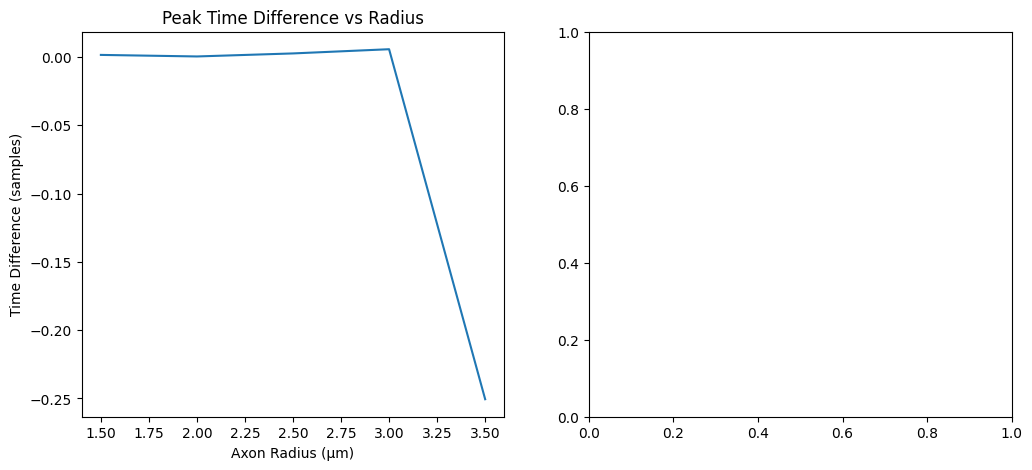

In [1]:
import straight_axon_model 
import jax.numpy as jnp
import jax
from loss_functions import sodium_peaks, diffusion_peaks, potassium_peaks, ei_widths, get_masked_eis, pairwise_time_differences

cell = straight_axon_model.StraightAxon()
params = cell.params

# Create array of radius values to sweep
radii = jnp.linspace(1.5, 3.5, 5)

# Initialize arrays to store results
time_diffs = []
widths = []
time_diffs_gradients = []
widths_gradients = []


def compute_time_diff(params, cell):
    eap, _, _ = cell.predict_ei(params)
    upsampled_eap = jax.image.resize(eap, (eap.shape[0]*20, eap.shape[1]), method='lanczos3')
    time_diffs_this_ei, normalized_ei = pairwise_time_differences(upsampled_eap, component='sodium')
    return time_diffs_this_ei[1,2]

def compute_width(params, cell):
    eap, _, _ = cell.predict_ei(params)
    upsampled_eap = jax.image.resize(eap, (eap.shape[0]*20, eap.shape[1]), method='lanczos3')
    return ei_widths(upsampled_eap, peak_value=10.0, component_one='sodium', component_two='potassium')[0]

jitted_compute_time_diff_grad = jax.jit(jax.value_and_grad(compute_time_diff))
jitted_compute_width_grad = jax.jit(jax.value_and_grad(compute_width))


# Sweep through radii
from tqdm import tqdm
for radius in tqdm(radii):
    # Update params with current radius
    params_copy = {**params}
    params_copy["radius"] = jnp.array([radius])

    opt_params = cell.inverse_sigmoid_transform_parameters(params_copy)
    # time_diff = cell.loss(opt_params)

    # time_diffs.append(float(time_diff))
    #time_diffs_gradients.append(float(gradient["radius"][0]))
    
    # time_diff, time_diff_gradient = jitted_compute_time_diff_grad(params_copy, cell)
    # width, width_gradient = jitted_compute_width_grad(params_copy, cell)
    # time_diffs.append(float(time_diff))
    # widths.append(float(width))

    # time_diffs_gradients.append(time_diff_gradient)
    # widths_gradients.append(gradient)

    #Get EI prediction for this radius
    eap, _, _ = cell.jitted_predict_ei(params_copy)
    upsampled_eap = jax.image.resize(eap, (eap.shape[0]*20, eap.shape[1]), method='lanczos3')

    # Calculate time difference between electrodes 1 and 2
    time_diffs_this_ei = pairwise_time_differences(upsampled_eap, component='sodium')
    time_diffs.append(float(time_diffs_this_ei[1,2]))
    
    # #Calculate EI width
    # width = jnp.mean(ei_widths(upsampled_eap, peak_value=10.0, component_one='sodium', component_two='potassium'))
    # widths.append(float(width))

    # if radius < 1.5:
    #     plt.figure()
    #     plt.plot(eap[400:600, 1], label='Electrode 1')
    #     plt.plot(eap[400:600, 2], label='Electrode 2')
    #     plt.xlabel('Time (samples)')
    #     plt.ylabel('Voltage (mV)')
    #     plt.title(f'EAP at r = {radius:.1f} μm, time difference = {time_diff:.1f} samples')
    #     plt.legend()

# Convert to arrays
time_diffs = jnp.array(time_diffs)
widths = jnp.array(widths)

import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(radii, time_diffs)
plt.xlabel('Axon Radius (μm)')
plt.ylabel('Time Difference (samples)')
plt.title('Peak Time Difference vs Radius')

plt.subplot(122)
plt.plot(radii, time_diffs_gradients)
plt.xlabel('Axon Radius (μm)')
plt.ylabel('Time Difference Gradient')
plt.title('Peak Time Difference Gradient vs Radius')

# plt.subplot(122)
# plt.plot(radii, widths)
# plt.xlabel('Axon Radius (μm)')
# plt.ylabel('EI Width (samples)')
# plt.title('EI Width vs Radius')

# plt.tight_layout()
# plt.show()


In [ ]:
# Sweep sodium conductance values
gNa_values = jnp.linspace(0.1, 0.3, 10)
time_diffs = []
widths = []

for gNa in tqdm(gNa_values):
    # Update params with current gNa
    params_copy = {**params}
    params_copy["HH_gNa"] = jnp.array([gNa])
    
    # Get EI prediction for this gNa
    eap, _, _ = cell.jitted_predict_ei(params_copy)
    
    # Calculate time difference between electrodes 1 and 2
    time_diff = pairwise_sodium_peak_time_differences(eap, normalize_beta=100.0)[1,2]
    time_diffs.append(float(time_diff))
    
    # Calculate EI width
    width = jnp.mean(ei_widths(eap, max_time_offset=40))
    widths.append(float(width))

    plt.figure()
    plt.plot(eap[:, 1], label='Electrode 1')
    plt.plot(eap[:, 2], label='Electrode 2')
    plt.xlabel('Time (samples)')
    plt.ylabel('Voltage (mV)')
    plt.title(f'EAP at gNa = {gNa:.2f}, time difference = {time_diff:.1f} samples')
    plt.legend()

# Convert to arrays
time_diffs = jnp.array(time_diffs)
widths = jnp.array(widths)

# Plot results
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(gNa_values, time_diffs)
plt.xlabel('Sodium Conductance (S/cm²)')
plt.ylabel('Time Difference (samples)')
plt.title('Peak Time Difference vs gNa')

plt.subplot(122)
plt.plot(gNa_values, widths)
plt.xlabel('Sodium Conductance (S/cm²)') 
plt.ylabel('EI Width (samples)')
plt.title('EI Width vs gNa')

plt.tight_layout()
plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'pairwise_sodium_peak_time_differences' is not defined

In [4]:
#test if gradient computation works

#results = jax.value_and_grad(cell.loss, argnums=0)(opt_params)











# # Plot membrane current for every 10th compartment
# plt.figure(figsize=(12, 4))
# plt.subplot(131)
# for i in range(0, mem_current.shape[1], 100):
#     plt.plot(mem_current[:, i], label=f'Comp {i}')
# plt.title('Membrane Current')
# plt.xlabel('Time')
# plt.ylabel('mA/cm²')
# plt.legend()

# # Plot membrane voltage for every 10th compartment
# plt.subplot(132)
# for i in range(0, mem_voltage.shape[1], 100):
#     plt.plot(mem_voltage[:,i], label=f'Comp {i}')
# plt.title('Membrane Voltage') 
# plt.xlabel('Time')
# plt.ylabel('mV')
# plt.legend()

# plt.tight_layout()
# plt.show()




# # Time subsequent calls to jitted_predict_ei
# import time

# print("Timing subsequent calls to jitted_predict_ei...")

# # First call already happened above, now time 10 more calls
# num_trials = 10
# times = []

# import numpy as np
# for i in range(num_trials):
#     start = time.time()
#     eap, mem_current, mem_voltage = cell.jitted_predict_ei(params)
#     end = time.time()
#     times.append(end - start)
#     print(f"Call {i+1} took {times[-1]:.4f} seconds")

# print(f"\nAverage time over {num_trials} calls: {np.mean(times):.4f} seconds")
# print(f"Standard deviation: {np.std(times):.4f} seconds")


# # Time multiple calls to jitted_predict_ei with different batch sizes
# print("\nTiming jitted_predict_ei with different batch sizes...")



# times = []
# for batch_size in range(10):
#     start = time.time()
#     val = cell.jitted_grad(opt_params)
#     end = time.time()
#     times.append(end - start)
#     print(f"Trial {i+1}: {times[-1]:.4f} seconds")

# print(f"\nAverage time over {num_trials} calls: {np.mean(times):.4f} seconds")
# print(f"Standard deviation: {np.std(times):.4f} seconds")   




In [5]:
import pickle as pkl
import importlib
import jax.numpy as jnp
import numpy as np

# Import and reload the model
import model
importlib.reload(model)

physical_ei = model.generate_random_gt_params_ei(1)


print("Creating trainer...")
trainer = model.StraightAxon()
print("Trainer created successfully!")
print("Training with physical_ei:", physical_ei)
trainer.train(true_ei=physical_ei)

ImportError: cannot import name 'ei_width_loss' from 'loss_functions' (/nfs/pool0/lotlikar/software/extracellular-jaxley/exp/loss_functions.py)

In [ ]:
normalized_eap = jax.nn.softmax(-10.0 * eap, axis=0)

print('normalized_eap.shape', normalized_eap.shape)

cross_corr = jnp.correlate(normalized_eap[:, 1], normalized_eap[:, 2], mode='full')

plt.figure()
plt.plot(normalized_eap[:, 1])
plt.plot(normalized_eap[:, 2])

plt.figure()
plt.plot(cross_corr[:])


print('length', normalized_eap.shape[0])
print('corr length', cross_corr.shape[0])

inner_product = jnp.sum(normalized_eap[:, 1] * normalized_eap[:, 2])
eff_cross = cross_corr[199]

time_offsets = jnp.arange(normalized_eap.shape[0]*2 -1) - normalized_eap.shape[0] + 1

print('comparison', inner_product, eff_cross)


print('offset', jnp.sum(time_offsets * cross_corr))

In [ ]:
# # Plot normalized EI
# plt.figure(figsize=(12, 4))
# for i in range(normalized_ei.shape[1]):
#     plt.plot(normalized_ei[:, i], label=f'Electrode {i}')
# plt.title('Normalized EI')
# plt.xlabel('Time')
# plt.ylabel('Probability')
# plt.legend()


sodium_ei, diffusion_ei, potassium_ei = get_masked_eis(upsampled_eap)

plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 5))

ax1.plot(sodium_ei[:,0])
ax1.set_title('Sodium Component')
ax1.set_ylabel('mV')

ax2.plot(diffusion_ei[:,0]) 
ax2.set_title('Diffusion Component')
ax2.set_ylabel('mV')

ax3.plot(potassium_ei[:,0])
ax3.set_title('Potassium Component') 
ax3.set_xlabel('Time')
ax3.set_ylabel('mV')

plt.tight_layout()

# Plot softmax of each component
plt.figure(figsize=(12,5))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Normalize beta for visualization
beta = 100.0

signal = jax.nn.softmax(-1*beta * sodium_ei[:,0])
ax1.plot(signal)
ax1.set_title('Sodium Component Softmax')
ax1.set_ylabel('Probability')

signal = jax.nn.softmax(beta * diffusion_ei[:,0])
ax2.plot(signal)
ax2.set_title('Diffusion Component Softmax')
ax2.set_ylabel('Probability')
plt.tight_layout()

signal = jax.nn.softmax(beta * potassium_ei[:,0])
ax3.plot(signal)
ax3.set_title('Potassium Component Softmax')
ax3.set_ylabel('Probability')
plt.tight_layout()